In [133]:
!pip install pyDOE

#you need to add a dataset with GaussJacobiQuadRule_V3 on the right 
import sys
#sys.path.insert(1, '/kaggle/input/quadrule')
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

#import GaussJacobiQuadRule_V3


import tensorflow as tf
print(tf.version)
#tf.disable_v2_behavior()
import pyDOE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3.py import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

<module 'tensorflow._api.v2.version' from '/home/mariano/Documenti/test/base/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


In [134]:
float_type_tf=tf.float64
float_type_np=np.float32


In [135]:
# -model
# -vpinn class
#
#
#
#

In [136]:
class parameters:
    def __init__(self,LR,Opt_Niter,N_Element,N_testfcn,N_Quad,lossb_weight,a,b):
        self.LR = LR
        self.Opt_Niter = Opt_Niter + 1
        self.var_form=2
        self.N_Element = N_Element
        self.N_testfcn = N_testfcn #number of test function
        self.N_Quad = N_Quad    #quadrature points 
        self.lossb_weight = lossb_weight #hyprparameter we may turn it up

        #params for the exact sol and boundary term
        self.omega = 8*np.pi
        self.amp = 1
        self.r1 = 80

        #ingredients for loss
        [self.x_quad, self.w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)
        

        self.test_quad_element = self.Test_fcn(self.N_testfcn, self.x_quad)
        self.d1test_quad_element, self.d2test_quad_element = self.dTest_fcn(self.N_testfcn, self.x_quad)


        [self.x_l, self.x_r] = [a, b]     #modify in the future if you want general (a,b) interval
        self.delta_x = (self.x_r - self.x_l)/N_Element
        self.grid = np.asarray([ self.x_l + i*self.delta_x for i in range(self.N_Element+1)])

        #build right side (it doesnt depend on the network)

        self.F_ext_total = []
        for e in range(self.N_Element):
            x_quad_element = self.grid[e] + (self.grid[e+1]-self.grid[e])/2*(self.x_quad+1)  #traslation of the element 

            jacobian = (self.grid[e+1]-self.grid[e])/2
            testfcn_element = np.asarray([ self.Test_f(n,self.x_quad)  for n in range(1, self.N_testfcn+1)])

            #this is fh calculated on the real nodal values summed over each real nodal values(which comes form CGL nodes )

            f_quad_element = self.f_ext(x_quad_element)
            F_ext_element  = jacobian*np.asarray([sum(self.w_quad*f_quad_element*testfcn_element[i]) for i in range(self.N_testfcn)])    
            F_ext_element = F_ext_element[:,None] 
            self.F_ext_total.append(F_ext_element)

        self.F_ext_total = np.asarray(self.F_ext_total)


        self.X_bound = np.asarray([a,b],dtype=float_type_np)[:,None]
        self.u_bound   = self.u_exact(self.X_bound)

    def u_exact(self,x):
        utemp = 0.1*np.sin(self.omega*x) + np.tanh(self.r1*x)
        return self.amp*utemp

    def f_ext(self,x):
        gtemp =  -0.1*(self.omega**2)*np.sin(self.omega*x) - (2*self.r1**2)*(np.tanh(self.r1*x))/((np.cosh(self.r1*x))**2)
        return -self.amp*gtemp

    def Test_f(self,n,x):
        test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
        return test
    
    def Test_fcn(self, N_test,x):
        test_total = []
        for n in range(1,N_test+1):  
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self, N_test,x):  #valuete the first and second derivatives of test functions on a point x 
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):  
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)

In [137]:
tfk=tf.keras
tfkl=tf.keras.layers
input_shape=(1,)
seed=42
input_layer = tfkl.Input(shape=input_shape, name='Input')
x1 = tfkl.Dense(20, activation=tf.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(input_layer)
x2 = tfkl.Dense(20, activation=tf.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x1)
x3 = tfkl.Dense(20, activation=tf.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x2)
x3 = tfkl.Dense(20, activation=tf.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x2)
output_layer = tfkl.Dense(1, activation='linear', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x3)


model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1)]               0         
                                                                 
 dense_70 (Dense)            (None, 20)                40        
                                                                 
 dense_71 (Dense)            (None, 20)                420       
                                                                 
 dense_73 (Dense)            (None, 20)                420       
                                                                 
 dense_74 (Dense)            (None, 1)                 21        
                                                                 
Total params: 901 (3.52 KB)
Trainable params: 901 (3.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [138]:
#pretraining
var_form=2
N_Element =5
N_testfcn =20 #number of test function
N_Quad =100    #quadrature points 
lossb_weight = 1.0 #hyprparameter we may turn it up

#params for the exact sol and boundary term
omega = 8*np.pi
amp = 1
r1 = 80

def u_exact(x):
    utemp = 0.1*np.sin(omega*x) + np.tanh(r1*x)
    return amp*utemp

def f_ext(x):
    gtemp =  -0.1*(omega**2)*np.sin(omega*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2)
    return -amp*gtemp

def Test_f(n,x):
    test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
    return test

def Test_fcn(N_test,x):
    test_total = []
    for n in range(1,N_test+1):  
        test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
        test_total.append(test)
    return np.asarray(test_total)



#ingredients for loss
[x_quad_,w_quad_] = GaussLobattoJacobiWeights(N_Quad, 0, 0)
    

test_quad_element = Test_fcn(N_testfcn,x_quad_)

a=-1.0
b=1.0
[x_l,x_r] = [a, b]     #modify in the future if you want general (a,b) interval

delta_x = (x_r - x_l)/N_Element
grid = np.asarray([ x_l + i*delta_x for i in range(N_Element+1)])


#build right side (it doesnt depend on the network)
F_ext_total = []

for e in range(N_Element):
    x_quad_element = grid[e] + (grid[e+1]-grid[e])/2*(x_quad_+1)  #traslation of the element 

    jacobian = (grid[e+1]-grid[e])/2
    testfcn_element = np.asarray([Test_f(n,x_quad_)  for n in range(1,N_testfcn+1)])

    #this is fh calculated on the real nodal values summed over each real nodal values(which comes form CGL nodes )

    f_quad_element =f_ext(x_quad_element)
    F_ext_element  = jacobian*np.asarray([sum(w_quad_*f_quad_element*testfcn_element[i]) for i in range(N_testfcn)])    
    F_ext_element = F_ext_element[:,None] 
    F_ext_total.append(F_ext_element)

F_ext_total = np.asarray(F_ext_total)


X_bound = np.asarray([a,b],dtype=float_type_np)[:,None]
u_bound   = u_exact(X_bound)

In [139]:
print(x_quad_.shape[0])
c = tf.Variable(tf.zeros(shape=(x_quad_.shape[0],1), dtype=tf.float64))
print(model(c))

100
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(100, 1), dtype=float32)


In [140]:
class VPINN:
    def __init__(self):

        self.xquad   = x_quad_
        self.wquad   =w_quad_ #weights for quadrature to calculate the loss
        
        
        self.F_ext_total =F_ext_total

        self.Nelement =N_Element #number of elements  
        self.N_test   = np.shape(self.F_ext_total[0])[0] #number of test function

        

        self.x_quad = tf.Variable(tf.zeros(shape=(x_quad_.shape[0],1), dtype=tf.float32))
      
        
        #ingredients for discrete integrals,remark the newtork is not just one you need to calculate in poisson case u(x,y) ,d/dx u(x,y) ,d/dy u(x,y)
        
        self.u_NN_quad  = model(self.x_quad) #x_quad is a row tensor 
        
        self.d1u_NN_quad, self.d2u_NN_quad = self.net_du(self.x_quad)
         
        self.test_quad=self.Test_fcn(self.N_test, self.xquad)
       	
        self.d1test_quad, self.d2test_quad = self.dTest_fcn(self.N_test, self.xquad)
        
 
        
#evaluete f through the network ??
        
        
        #start from there -> loss calculation
    def calculate_loss(self):    
        varloss_total = 0.0
        for e in range(self.Nelement):
            F_ext_element  = self.F_ext_total[e]
            Ntest_element  = np.shape(F_ext_element)[0] #for each element of the grid you have a vector of the focing term (suppose its n-loc),so the you can have at most quad formula n_loc
            
            x_quad_element = tf.constant(grid[e] + (grid[e+1]-grid[e])/2*(self.xquad+1))
            x_b_element    = tf.constant(np.array([[grid[e]], [grid[e+1]]]))
            #to change change integral to the ref segment in (-1,1)
            jacobian       = (grid[e+1]-grid[e])/2

            test_quad_element = self.Test_fcn(Ntest_element, self.xquad)
            d1test_quad_element, d2test_quad_element = self.dTest_fcn(Ntest_element, self.xquad)
            u_NN_quad_element = model(x_quad_element)
            d1u_NN_quad_element, d2u_NN_quad_element = self.net_du(x_quad_element)

            u_NN_bound_element = model(x_b_element)
            d1test_bound_element, d2test_bounda_element = self.dTest_fcn(Ntest_element, np.array([[-1],[1]]))


            if var_form == 1:
                U_NN_element = tf.reshape(tf.stack([-jacobian*tf.reduce_sum(self.wquad*d2u_NN_quad_element*test_quad_element[i]) \
                                                    for i in range(Ntest_element)]),(-1,1))
            if var_form == 2:
                U_NN_element = tf.reshape(tf.stack([ tf.reduce_sum(self.wquad*d1u_NN_quad_element*d1test_quad_element[i]) \
                                                    for i in range(Ntest_element)]),(-1,1))                                 #i think we are going to use this most of the times 
            if var_form == 3:
                U_NN_element = tf.reshape(tf.stack([-1/jacobian*tf.reduce_sum(self.wquad*u_NN_quad_element*d2test_quad_element[i]) \
                                                    +1/jacobian*tf.reduce_sum(u_NN_bound_element*np.array([-d1test_bound_element[i][0], d1test_bound_element[i][-1]]))  \
                                                    for i in range(Ntest_element)]),(-1,1))


            Res_NN_element = U_NN_element - F_ext_element
            loss_element = tf.reduce_mean(tf.square(Res_NN_element))
            varloss_total =varloss_total + loss_element



        lossb = tf.reduce_mean(tf.square(model(X_bound) - u_bound)) #u_NN_pred is what your network has calc,while u_tf is the real value
        lossv =tf.cast(varloss_total,tf.float32)
        #two losses 
        return lossb,lossv
    
    def net_du(self,x): #calculates first and second derivatives of the input unn d/dx unn d^2/dx^2 unn so it can compute loss
        with tf.GradientTape() as tape:
            tape.watch(x)
            with tf.GradientTape() as tape_:
                tape_.watch(x)
                output=model(x)
            d1u=tape_.gradient(output,x)
        d2u=tape.gradient(d1u,x)
        return d1u, d2u

###############################################################################  
    #vtest functions == jacobi polynomils valueted on a point x
    def Test_fcn(self,N_test,x):
        test_total = []
        for n in range(1,N_test+1):  
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self,N_test,x):  #valuete the first and second derivatives of test functions on a point x 
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):  
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)
        

    def train(self):
        tf.compat.v1.enable_eager_execution()
        total_record=[]
        nIter=5000

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        start_time       = time.time()
        for epoch in range(nIter+1):
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_variables)
                loss_valueb,loss_valuev=self.calculate_loss()
                loss=loss_valueb*lossb_weight+loss_valuev
                
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
            # Print training loss for this epoch
            if (epoch) % 10 == 0:
                        elapsed = time.time() - start_time
                        str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Time: %.2f'
                        print(str_print % (epoch, loss_valueb, loss_valuev, elapsed))
                        start_time = time.time()        
                        total_record.append(np.array([epoch, loss,loss_valueb,loss_valuev]))


        return total_record


In [141]:
test=VPINN()
total_record=[]
total_record=test.train()

It: 0, Lossb: 1.463e-02, Lossv: 8.660e+02, Time: 0.27
It: 10, Lossb: 1.661e-05, Lossv: 8.660e+02, Time: 2.61
It: 20, Lossb: 7.659e-04, Lossv: 8.660e+02, Time: 2.54
It: 30, Lossb: 1.891e-04, Lossv: 8.660e+02, Time: 2.59
It: 40, Lossb: 1.018e-04, Lossv: 8.660e+02, Time: 2.56
It: 50, Lossb: 1.182e-04, Lossv: 8.660e+02, Time: 2.60
It: 60, Lossb: 1.356e-05, Lossv: 8.659e+02, Time: 2.69
It: 70, Lossb: 1.111e-03, Lossv: 8.657e+02, Time: 2.47
It: 80, Lossb: 8.962e-03, Lossv: 8.650e+02, Time: 2.50
It: 90, Lossb: 1.735e-02, Lossv: 8.631e+02, Time: 2.50
It: 100, Lossb: 4.066e-05, Lossv: 8.582e+02, Time: 2.56
It: 110, Lossb: 1.143e-02, Lossv: 8.454e+02, Time: 2.56
It: 120, Lossb: 1.392e-02, Lossv: 8.243e+02, Time: 2.49
It: 130, Lossb: 1.374e-02, Lossv: 8.119e+02, Time: 2.49
It: 140, Lossb: 3.643e-02, Lossv: 8.054e+02, Time: 2.52
It: 150, Lossb: 7.439e-02, Lossv: 8.014e+02, Time: 2.53
It: 160, Lossb: 1.694e-02, Lossv: 7.964e+02, Time: 2.56
It: 170, Lossb: 3.571e-02, Lossv: 7.910e+02, Time: 2.54
It:

KeyboardInterrupt: 

TypeError: object of type 'function' has no len()

<Figure size 640x480 with 0 Axes>

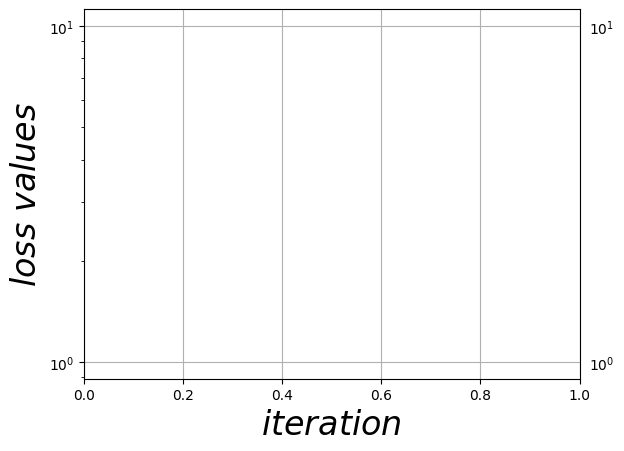

In [ ]:
x_test=tf.convert_to_tensor(np.linspace(-1,1,100),tf.float32)
y_test=tf.convert_to_tensor(u_exact(x_test))


u_pred=model(x_test)
y_test=tf.expand_dims(y_test,axis=1)

fig = plt.figure(0)
gridspec.GridSpec(3,1)


# plt.savefig('Train-Quad-pnts.pdf')    
#++++++++++++++++++++++++++++

font = 24
#all loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('loss.pdf')
#++++++++++++++++++++++++++++
#partial loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
loss_b  = [total_record[i][2] for i in range(len(total_record))]
loss_v  = [total_record[i][3] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.plot(iteration, loss_b,'blue',label="boundary_loss")
plt.plot(iteration, loss_v, 'violet',label="variational_loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()


pnt_skip = 25
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)

plt.xlabel('$x$', fontsize = font)
plt.ylabel('$u$', fontsize = font)
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(x_test, y_test, linewidth=1, color='r', label=''.join(['$exact$']))
plt.plot(x_test, u_pred, 'k*', label='$VPINN$')
plt.tick_params( labelsize = 20)
legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('prediction.pdf')
#++++++++++++++++++++++++++++

fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('point-wise error', fontsize = font)
plt.yscale('log')
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(x_test, abs(y_test - u_pred), 'k')
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()